# Backtest

In [103]:
import pandas as pd

historical_data = pd.read_csv('../../reports/hist_data.csv')
historical_data.tail()

,Date,news,finance,tech,head
63,06.03.2025,7,6.0,6.0,6.5
64,08.03.2025,5,4.0,7.0,5.5
65,10.03.2025,5,3.0,7.0,5.0
66,10.03.2025,5,4.0,8.0,5.5
67,12.03.2025,5,3.0,7.0,5.0


In [104]:
from datetime import datetime, timedelta
import yfinance as yf

def download_yfinance_data(ticker_symbol: str,
                           start_date: datetime,
                           asset: str,
                           end_date: datetime) -> pd.DataFrame:

    # Download the data
    yfinance_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')
    yfinance_data.columns = yfinance_data.columns.droplevel(1)  # Drops the second level ('BTC-USD')
    yfinance_data.reset_index(inplace=True) # Reset the index to have the 'Date' as a column

    # Modify the DataFrame to include the ticker symbol and asset type
    yfinance_data['ticker'] = ticker_symbol
    yfinance_data['asset'] = asset

    yfinance_data = yfinance_data.rename(
        columns={'Price': 'price',
                 'Adj Close': 'adj_close',
                 'Close': 'close',
                 'High': 'high',
                 'Low': 'low',
                 'Open': 'open',
                 'Volume': 'volume',
                 'Date': 'date'})

    return yfinance_data


data = download_yfinance_data(
    ticker_symbol='BTC-USD',
    start_date=datetime.now() - timedelta(days=150),
    asset='bitcoin',
    end_date=datetime.now()
    )

data.tail()

[*********************100%***********************]  1 of 1 completed


Price,date,close,high,low,open,volume,ticker,asset
146,2025-03-08,86154.593750,86847.265625,85247.484375,86742.656250,18206118081,BTC-USD,bitcoin
147,2025-03-09,80601.039062,86471.132812,80052.484375,86154.304688,30899345977,BTC-USD,bitcoin
148,2025-03-10,78532.000000,83955.929688,77420.593750,80597.148438,54061099422,BTC-USD,bitcoin
149,2025-03-11,82862.210938,83577.757812,76624.250000,78523.875000,54702837196,BTC-USD,bitcoin
150,2025-03-12,82713.359375,83737.453125,81295.734375,82902.789062,47343599616,BTC-USD,bitcoin


In [105]:
# Convert 'Pricedate' and 'Date' to datetime objects for accurate merging
data['date'] = pd.to_datetime(data['date'])
historical_data['date'] = pd.to_datetime(historical_data['Date'], format='%d.%m.%Y') # or format='%d.%m.%Y' depending on your date format.


In [106]:
# Merge the DataFrames on 'Pricedate'
merged_df = pd.merge(data, historical_data, on='date', how='left') # left keeps all rows from df1

#merged_df = merged_df[merged_df['date'].dt.month >= 10]
#merged_df = merged_df[merged_df['date'].dt.year >= 2024]

In [107]:
merged_df.tail()

,date,close,high,low,open,volume,ticker,asset,Date,news,finance,tech,head
150,2025-03-09,80601.039062,86471.132812,80052.484375,86154.304688,30899345977,BTC-USD,bitcoin,NaN,NaN,NaN,NaN,NaN
151,2025-03-10,78532.000000,83955.929688,77420.593750,80597.148438,54061099422,BTC-USD,bitcoin,10.03.2025,5.0,3.0,7.0,5.0
152,2025-03-10,78532.000000,83955.929688,77420.593750,80597.148438,54061099422,BTC-USD,bitcoin,10.03.2025,5.0,4.0,8.0,5.5
153,2025-03-11,82862.210938,83577.757812,76624.250000,78523.875000,54702837196,BTC-USD,bitcoin,NaN,NaN,NaN,NaN,NaN
154,2025-03-12,82713.359375,83737.453125,81295.734375,82902.789062,47343599616,BTC-USD,bitcoin,12.03.2025,5.0,3.0,7.0,5.0


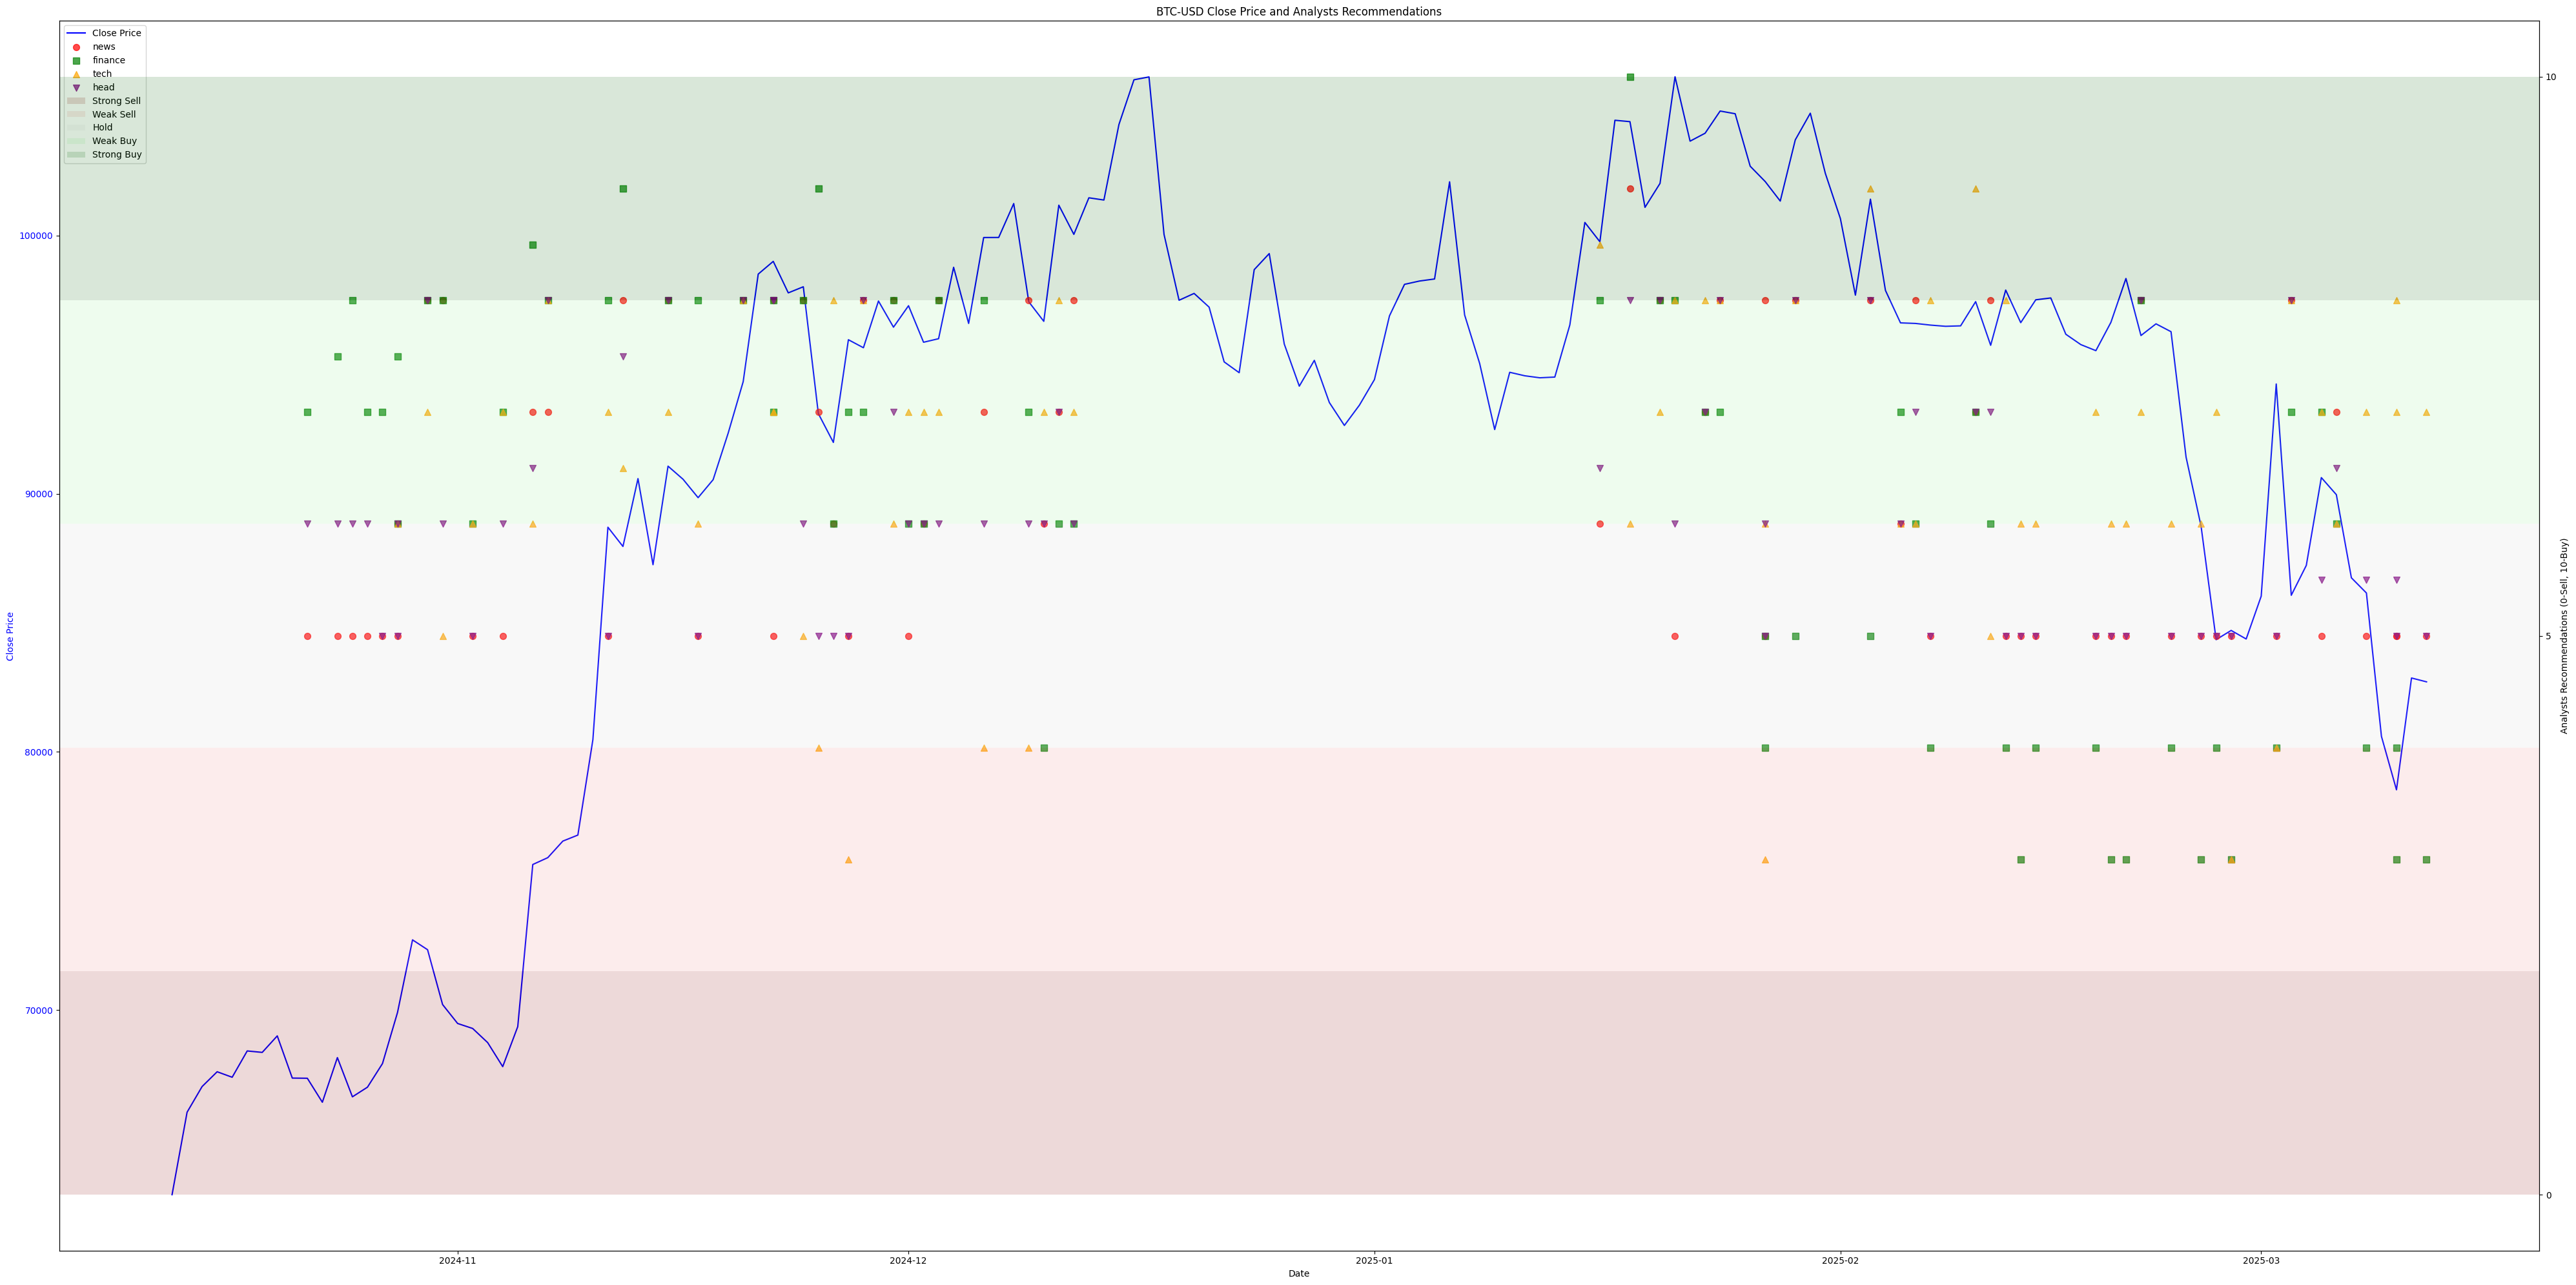

In [108]:
import matplotlib.pyplot as plt


merged_df['date'] = pd.to_datetime(merged_df['date'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(40, 20))

# Plot 'close' price as a line chart
ax1.plot(merged_df['date'], merged_df['close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the analysts' recommendations
ax2 = ax1.twinx()

# Plot the analysts' recommendations as scatter plots with vertical lines
analysts = ['news', 'finance', 'tech', 'head']
colors = ['red', 'green', 'orange', 'purple']
markers = ['o', 's', '^', 'v']  # Different markers for each analyst

for i, analyst in enumerate(analysts):
    ax2.scatter(merged_df['date'], merged_df[analyst], color=colors[i], marker=markers[i], label=analyst, alpha=0.7, s=50) #added alpha and s to change marker transparency and size.



ax2.set_ylabel('Analysts Recommendations (0-Sell, 10-Buy)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_yticks([0, 5, 10])

# Add recommendation band
ax2.axhspan(0, 2, facecolor='darkred', alpha=0.15, label='Strong Sell')
ax2.axhspan(2, 4, facecolor='lightcoral', alpha=0.15, label='Weak Sell')
ax2.axhspan(4, 6, facecolor='lightgray', alpha=0.15, label='Hold')
ax2.axhspan(6, 8, facecolor='lightgreen', alpha=0.15, label='Weak Buy')
ax2.axhspan(8, 10, facecolor='darkgreen', alpha=0.15, label='Strong Buy')

# Add title and legend
plt.title('BTC-USD Close Price and Analysts Recommendations')

# Create a more informative legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
unique = []
for h, l in zip(handles, labels):
    if l not in [label for handle, label in unique]:
        unique.append((h, l))

ax1.legend(*zip(*unique), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

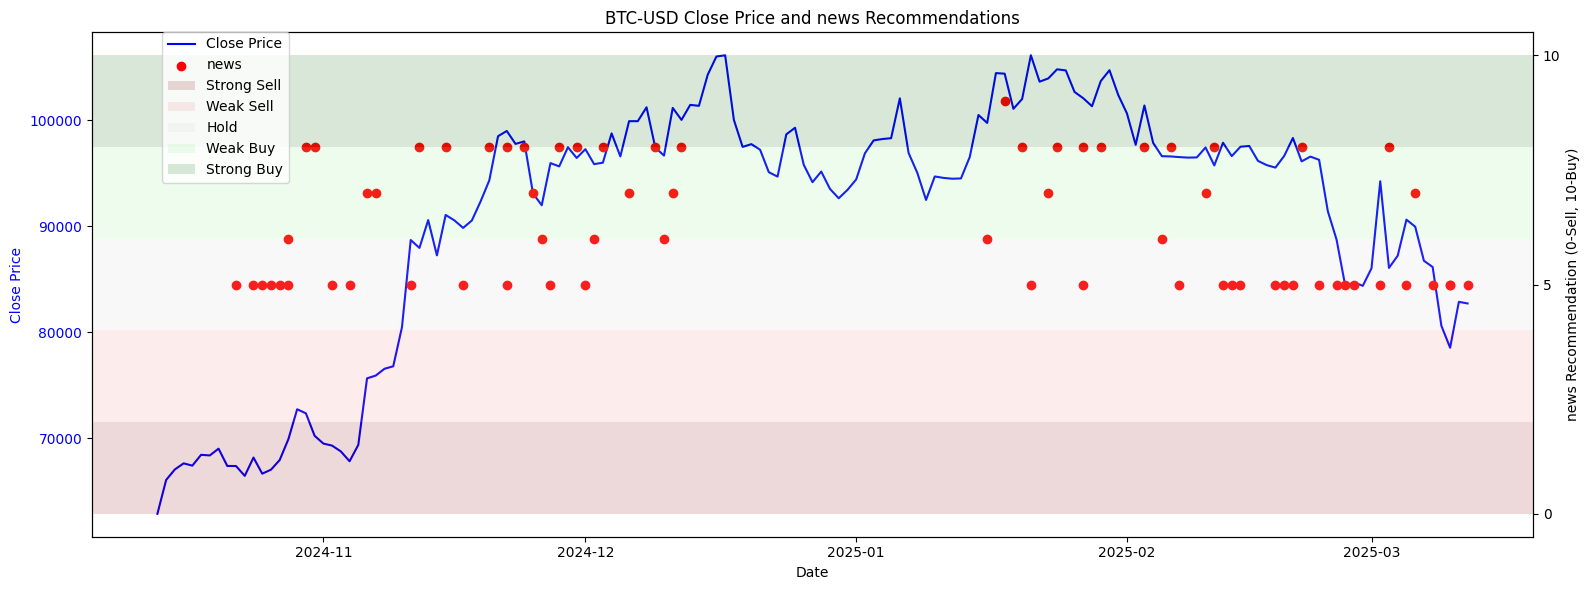

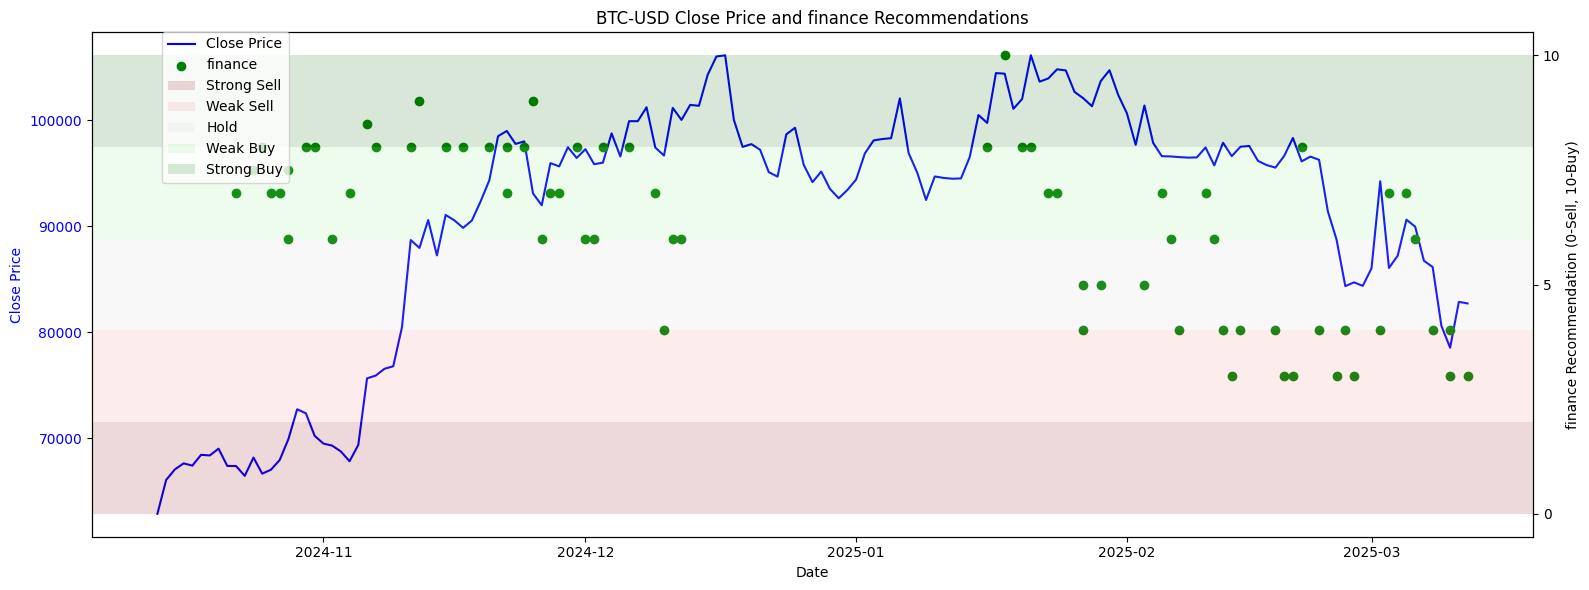

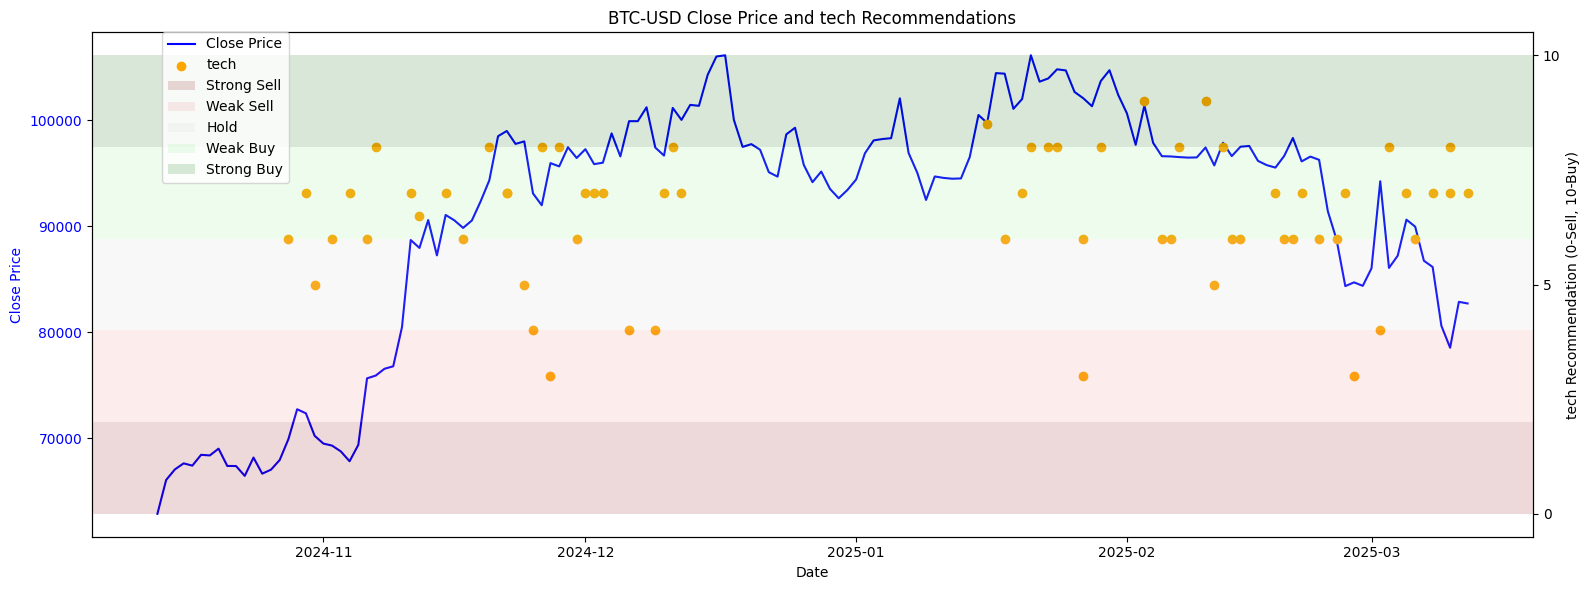

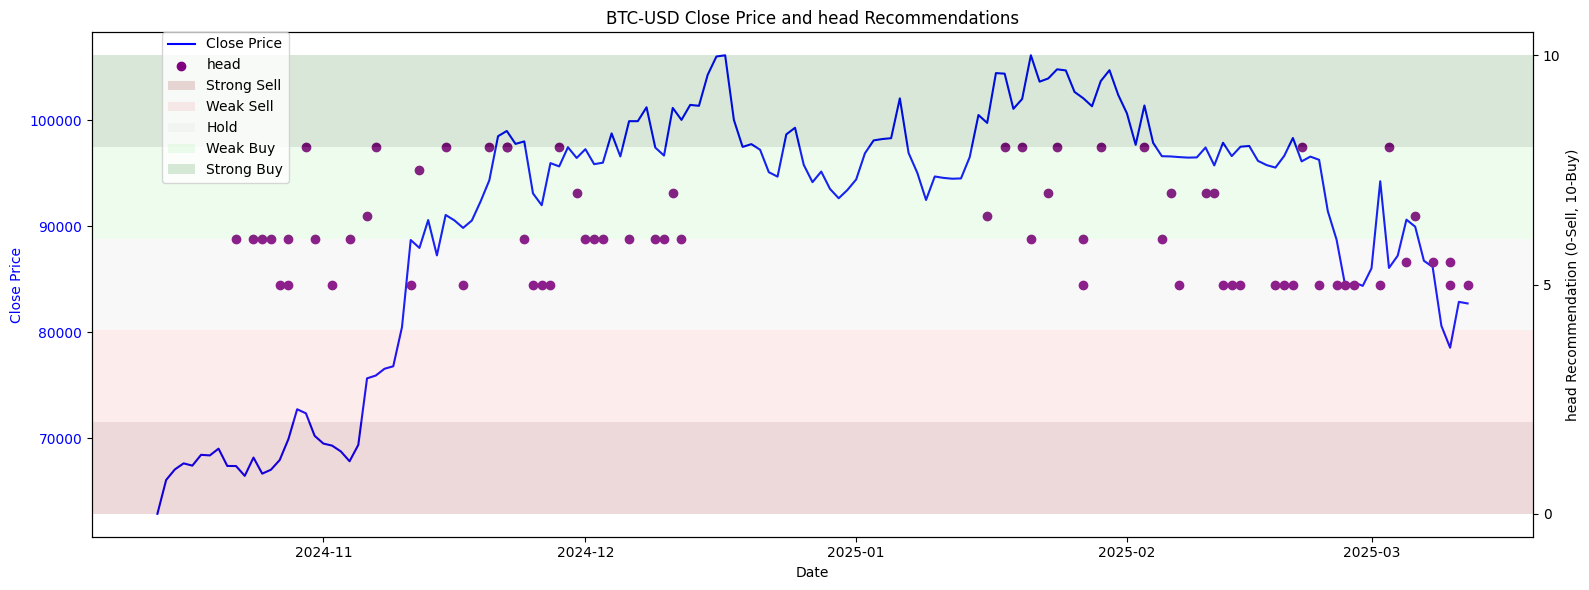

In [109]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Analysts list
analysts = ['news', 'finance', 'tech', 'head']
colors = ['red', 'green', 'orange', 'purple']

# Create a plot for each analyst
for i, analyst in enumerate(analysts):
    fig, ax1 = plt.subplots(figsize=(16, 6))

    # Plot 'close' price as a line chart
    ax1.plot(merged_df['date'], merged_df['close'], color='blue', label='Close Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for the analyst's recommendations
    ax2 = ax1.twinx()

    # Plot the analyst's recommendations as scatter plots with vertical lines
    ax2.scatter(merged_df['date'], merged_df[analyst], color=colors[i], marker='o', label=analyst)

    ax2.set_ylabel(f'{analyst} Recommendation (0-Sell, 10-Buy)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_yticks([0, 5, 10])

    # Add recommendation band
    ax2.axhspan(0, 2, facecolor='darkred', alpha=0.15, label='Strong Sell')
    ax2.axhspan(2, 4, facecolor='lightcoral', alpha=0.15, label='Weak Sell')
    ax2.axhspan(4, 6, facecolor='lightgray', alpha=0.15, label='Hold')
    ax2.axhspan(6, 8, facecolor='lightgreen', alpha=0.15, label='Weak Buy')
    ax2.axhspan(8, 10, facecolor='darkgreen', alpha=0.15, label='Strong Buy')

    # Add title and legend
    plt.title(f'BTC-USD Close Price and {analyst} Recommendations')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
# Convert 'date' to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Analysts list
analysts = ['news', 'finance', 'tech', 'head']

# Initial capital
initial_capital = 10000

# Store results
results = {}

# Backtest for each analyst
for analyst in analysts:
    capital = initial_capital
    shares = 0
    transactions = []

    for i in range(len(merged_df) - 1):
        recommendation = merged_df[analyst].iloc[i]
        open_price = merged_df['open'].iloc[i + 1]

        if recommendation <= 4 and shares > 0:  # Sell signal
            capital += shares * open_price
            transactions.append({
                'date': merged_df['date'].iloc[i + 1],
                'action': 'sell',
                'price': open_price,
                'shares': shares,
                'capital': capital
            })
            shares = 0
            print(f'{analyst}: Sold {shares} shares at ${open_price:.2f}')
        elif recommendation >= 6 and capital >= open_price:  # Buy signal and enough capital
            shares = capital // open_price
            capital -= shares * open_price
            transactions.append({
                'date': merged_df['date'].iloc[i + 1],
                'action': 'buy',
                'price': open_price,
                'shares': shares,
                'capital': capital
            })
            print(f'{analyst}: Bought {shares} shares at ${open_price:.2f}')

    # Close out any remaining shares on the last day.
    if shares > 0:
        capital += shares * merged_df['close'].iloc[-1]
        transactions.append({
            'date': merged_df['date'].iloc[-1],
            'action': 'sell',
            'price': merged_df['close'].iloc[-1],
            'shares': shares,
            'capital': capital
        })
        shares = 0
        print(f'{analyst}: Closed out {shares} shares at ${merged_df["close"].iloc[-1]:.2f}')

    # Calculate final portfolio value
    final_portfolio_value = capital

    # Calculate returns
    returns = (final_portfolio_value - initial_capital) / initial_capital

    results[analyst] = {
        'final_portfolio_value': final_portfolio_value,
        'returns': returns
    }

# Display results
print("Backtest Results:")
for analyst, result in results.items():
    print(f"\n{analyst} Strategy:")
    print(f"  Final Portfolio Value: ${result['final_portfolio_value']:.2f}")
    print(f"  Returns: {result['returns']:.2%}")

Backtest Results:

news Strategy:
  Final Portfolio Value: $10000.00
  Returns: 0.00%

finance Strategy:
  Final Portfolio Value: $10000.00
  Returns: 0.00%

tech Strategy:
  Final Portfolio Value: $10000.00
  Returns: 0.00%

head Strategy:
  Final Portfolio Value: $10000.00
  Returns: 0.00%


In [ ]:
# Convert 'date' to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Analysts list
analysts = ['news', 'finance', 'tech', 'head']

transactions = []
initial_capital = 10000
shares = 0
capital = initial_capital
results = {}

for i in range(len(merged_df) - 1):
    recommendation = merged_df["news"].iloc[i] # recommendation for the current day (t)
    open_price = merged_df['open'].iloc[i + 1] # open price for the next day (t+1)

    if recommendation <= 4 and shares > 0:  # Sell signal
        capital += shares * open_price
        transactions.append({
            'date': merged_df['date'].iloc[i + 1],
            'action': 'sell',
            'price': open_price,
            'shares': shares,
            'capital': capital
        })
        print(f'{analyst}: Sold {shares} shares at ${open_price:.2f}, value sold {capital:.2f}')
        shares = 0

    elif recommendation >= 6 and capital > 5000:  # Buy signal and enough capital
        print(f'buying power: {capital:.5f}')
        shares = capital / open_price
        capital -= shares * open_price
        transactions.append({
            'date': merged_df['date'].iloc[i + 1],
            'action': 'buy',
            'price': open_price,
            'shares': shares,
            'capital': capital
        })
        print(f'{analyst}: Bought {shares} shares at ${open_price:.2f} capital {capital:.2f} - value bought {shares * open_price - capital:.2f}')


    if shares > 0 and merged_df['close'].iloc[i] == merged_df['date'].iloc[-1]:
        capital += shares * merged_df['close'].iloc[-1]
        transactions.append({
            'date': merged_df['date'].iloc[-1],
            'action': 'sell',
            'price': merged_df['close'].iloc[-1],
            'shares': shares,
            'capital': capital
        })
        shares = 0
        print(f'{analyst}: Closed out {shares} shares at ${merged_df["close"].iloc[-1]:.2f}')

print(f'capital: {(capital / initial_capital)-1}')

buying power: 10000.00000
head: Bought 0.14845082288146758 shares at $67362.38 capital 0.00 - value bought 10000.00
capital: -1.0


In [122]:
merged_df["finance"].describe()

count    68.000000
mean      6.257353
std       1.861817
min       3.000000
25%       4.000000
50%       7.000000
75%       8.000000
max      10.000000
Name: finance, dtype: float64